# Her analysere vi dataen ift til primacy og recall osv 

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast

### Loader data

In [29]:
# Loader dataen
df = pd.read_csv('../recall_experiment/data/free_recall_results.csv')

### Opskriver funktioner 

In [30]:
# Nedenstående funktion Konverterer strings som "[reef, road, diva, duck, coin]"
# til faktiske lister som ['reef', 'road', 'diva', 'duck','coin']

def parse_word_list(word_string):
    """Parse string representation of list into actual list"""
    if pd.isna(word_string) or word_string == '[]':
        return []
    try:
        # Remove quotes and brackets, then split by comma
        cleaned = word_string.strip('[]"')
        if not cleaned:
            return []
        words = [word.strip(' "\'') for word in cleaned.split(',')]
        return [word for word in words if word]
    except:
        return []

In [31]:
def calculate_metrics(presented, recalled):
    """Calculate primacy, recency and accuracy for 15-word lists"""
    # tjekker at listen er korrekt: 
    if len(presented) != 15:
        return {'primacy': 0, 'recency': 0, 'accuracy': 0}
    if not recalled:
        return {'primacy': 0, 'recency': 0, 'accuracy': 0}
    
    # Cleaner recalled words (lowercase, og remove duplicates)
    recalled_clean = []
    for word in recalled:
        if word and word.strip():
            word_clean = word.strip().lower()
            if word_clean not in recalled_clean:
                recalled_clean.append(word_clean)
    
    # cleaner presented words (lowercase)
    presented_clean = [word.strip().lower() for word in presented]
    
    # Accuracy: 
    correct_recalls = sum(1 for word in recalled_clean if word in presented_clean)
    accuracy = correct_recalls / 15
    
    # Primacy: første 5 ord
    primacy_words = presented_clean[:5]
    primacy_recalled = sum(1 for word in recalled_clean if word in primacy_words)
    primacy = primacy_recalled / 5
    
    # Recency: sidste 5 ord
    recency_words = presented_clean[-5:]
    recency_recalled = sum(1 for word in recalled_clean if word in recency_words)
    recency = recency_recalled / 5
    
    return {
        'primacy': primacy,
        'recency': recency, 
        'accuracy': accuracy
    }

### Bruger vores to ovenstående funktioner: 

In [34]:
# parser ordene
df['presented_list'] = df['presented_words'].apply(parse_word_list)
df['recalled_list'] = df['recalled_words'].apply(parse_word_list)

# Regner metrics for hver række
results = []
for _, row in df.iterrows():
    metrics = calculate_metrics(row['presented_list'], row['recalled_list'])
    metrics['trial'] = row['trial']
    results.append(metrics)

results_df = pd.DataFrame(results)
print(results_df.head())

   primacy  recency  accuracy  trial
0      0.8      0.6  0.466667      1
1      0.4      0.6  0.333333      2
2      0.0      1.0  0.333333      3


In [ ]:
# Summary statistics
print("\nFree Recall Analysis - Summary Statistics:")
print(f"Average Accuracy: {results_df['accuracy'].mean():.3f}")
print(f"Average Primacy: {results_df['primacy'].mean():.3f}")
print(f"Average Recency: {results_df['recency'].mean():.3f}")
print(f"Primacy vs Recency difference: {results_df['recency'].mean() - results_df['primacy'].mean():.3f}")


Free Recall Analysis - Summary Statistics:
Average Accuracy: 0.378
Average Primacy (first 5): 0.400
Average Recency (last 5): 0.733
Primacy vs Recency difference: 0.333


### Funktion til Serial Position Curve (SPC)

In [ ]:
# Serial Position Curve Analysis
def serial_position_analysis(df):
    position_recalls = [0] * 15
    position_totals = [0] * 15
    
    for _, row in df.iterrows():
        presented = row['presented_list']
        recalled = row['recalled_list']
        
        if len(presented) != 15 or not recalled:
            continue
            
        presented_clean = [word.strip().lower() for word in presented]
        recalled_clean = [word.strip().lower() for word in recalled if word and word.strip()]
        
        for pos in range(15):
            position_totals[pos] += 1
            if presented_clean[pos] in recalled_clean:
                position_recalls[pos] += 1
    
    recall_probs = [recalls/total if total > 0 else 0 
                   for recalls, total in zip(position_recalls, position_totals)]
    
    return recall_probs

### Ultimate Giga plot

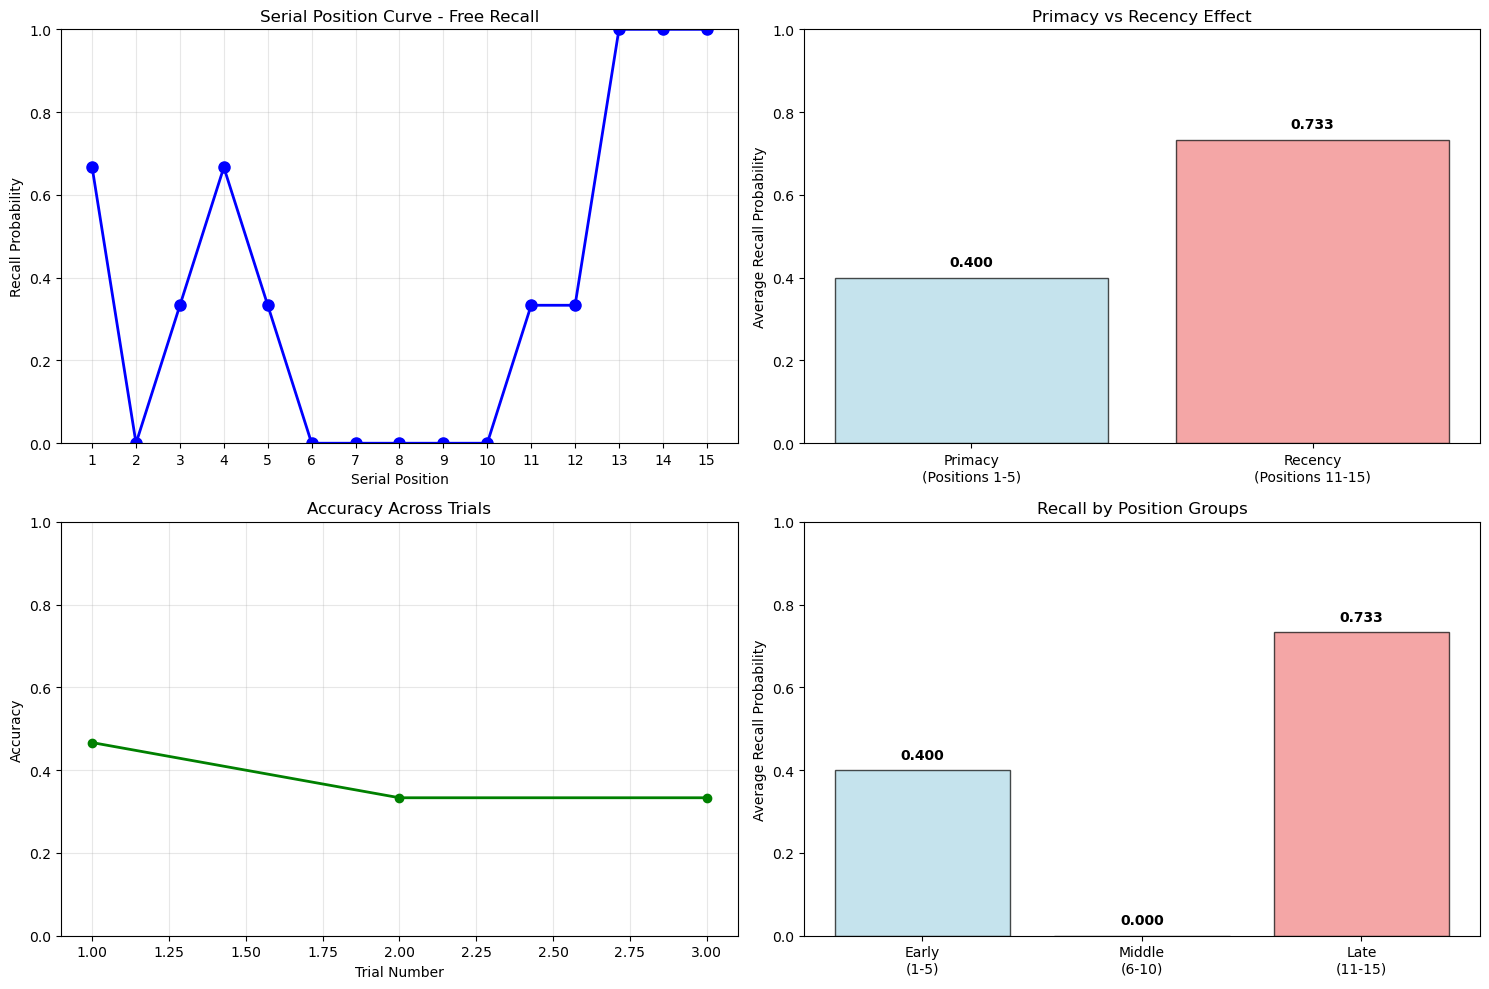

In [38]:
# Get serial position data
recall_probs = serial_position_analysis(df)
positions = list(range(1, 16))

# Create plots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# 1. Serial Position Curve
ax1.plot(positions, recall_probs, 'bo-', linewidth=2, markersize=8)
ax1.set_xlabel('Serial Position')
ax1.set_ylabel('Recall Probability')
ax1.set_title('Serial Position Curve - Free Recall')
ax1.grid(True, alpha=0.3)
ax1.set_ylim(0, 1)
ax1.set_xticks(range(1, 16))

# 2. Primacy vs Recency
categories = ['Primacy\n(Positions 1-5)', 'Recency\n(Positions 11-15)']
values = [results_df['primacy'].mean(), results_df['recency'].mean()]
colors = ['lightblue', 'lightcoral']

bars = ax2.bar(categories, values, color=colors, alpha=0.7, edgecolor='black')
ax2.set_ylabel('Average Recall Probability')
ax2.set_title('Primacy vs Recency Effect')
ax2.set_ylim(0, 1)

for bar, value in zip(bars, values):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
             f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

# 3. Accuracy by Trial
ax3.plot(results_df['trial'], results_df['accuracy'], 'go-', linewidth=2, markersize=6)
ax3.set_xlabel('Trial Number')
ax3.set_ylabel('Accuracy')
ax3.set_title('Accuracy Across Trials')
ax3.grid(True, alpha=0.3)
ax3.set_ylim(0, 1)

# 4. Position Groups
positions_grouped = ['Early\n(1-5)', 'Middle\n(6-10)', 'Late\n(11-15)']
early_prob = np.mean(recall_probs[:5])
middle_prob = np.mean(recall_probs[5:10]) 
late_prob = np.mean(recall_probs[10:15])

values_grouped = [early_prob, middle_prob, late_prob]
colors_grouped = ['lightblue', 'lightgray', 'lightcoral']

bars2 = ax4.bar(positions_grouped, values_grouped, color=colors_grouped, alpha=0.7, edgecolor='black')
ax4.set_ylabel('Average Recall Probability')
ax4.set_title('Recall by Position Groups')
ax4.set_ylim(0, 1)

for bar, value in zip(bars2, values_grouped):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
             f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

In [39]:
# Display results
print("\nDetailed Results:")
print(results_df)

print("\nRecall probability by position:")
for i, prob in enumerate(recall_probs, 1):
    print(f"Position {i:2d}: {prob:.3f}")


Detailed Results:
   primacy  recency  accuracy  trial
0      0.8      0.6  0.466667      1
1      0.4      0.6  0.333333      2
2      0.0      1.0  0.333333      3

Recall probability by position:
Position  1: 0.667
Position  2: 0.000
Position  3: 0.333
Position  4: 0.667
Position  5: 0.333
Position  6: 0.000
Position  7: 0.000
Position  8: 0.000
Position  9: 0.000
Position 10: 0.000
Position 11: 0.333
Position 12: 0.333
Position 13: 1.000
Position 14: 1.000
Position 15: 1.000
